<a href="https://colab.research.google.com/github/Israa200/Movie_Project/blob/master/Copy_of_Brain_Tumor_Segmentation_U_Net_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lgg-mri-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F181273%2F407317%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240826%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240826T120722Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D11c916813486891b5942379c8049ee2df277ac559c1c379a1d9ae06d047258ebddc18290137451dfc1a3997ade40d41c59d2cdab555a321f5fdfa70ab860c946aae4b9645b865686852ffaa8f785be8aa7819c62b5b7e9ef5b9ac5d1820281a4f6c5b9a8f82155f069ff0a895ba0d57f5f0a2518b7d6145a95ee1c1159e6eaebf87279e3e3f1edf911918270944035bdbb21296e060946c4dc9a6486cbd1a39076c605b1d22bf02eb281220687adfb0a544becef02f592198da48746b5f398988886744e3b3222c192699e95218eeaabe70d05a648d9a274e8d0978c9e95d836799c80feaa093212a240d95e221744c37ba8b61f0c7a68d158517ce4ef67217d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 748584920 bytes downloaded
Downloaded and uncompressed: lgg-mri-segmentation
Data source import complete.


## Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob  # Filename pattern matching
import random
import cv2  # Computer vision
from PIL import Image  # Image processing

import torch
import torchvision  # Computer vision tools
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Neural network functions
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as tt  # Image transformations
import albumentations as A  # Image augmentations
from tqdm import tqdm  # Progress bar
from mpl_toolkits.axes_grid1 import ImageGrid  # Image grid layout
from torch.utils.data import DataLoader  # Data loading
from torchvision.utils import make_grid  # Create image grids
from sklearn.model_selection import train_test_split

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise CPU
print("Using {} device".format(device))  # Print the selected device

Using cuda device


In [ ]:
def set_seed(seed=0):  # Function to set random seed for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)  #
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

## Load files path in a dataframe

In [ ]:
ROOT_PATH = '../input/lgg-mri-segmentation/kaggle_3m/'

# Using glob.glob to collect paths of all mask files in subdirectories
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

# Defining a function diagnosis(mask_path) that returns 1
#if the maximum pixel value in the mask image (read using cv2) is greater than 0
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
...,...,...,...
3924,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
3925,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
3926,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3927,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0


In [ ]:
# Displaying the distribution of diagnoses (0: No Tumor, 1: Tumor) in the DataFrame files_df
# and adding labels indicating the total number of images for each category.
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

Total of No Tumor: 2556
Total of Tumor: 1373


In [ ]:
# Splitting the dataset into training data (train_df), validation data (val_df),
#and test data (test_df) with specified proportions.
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


## Viewing the dataset

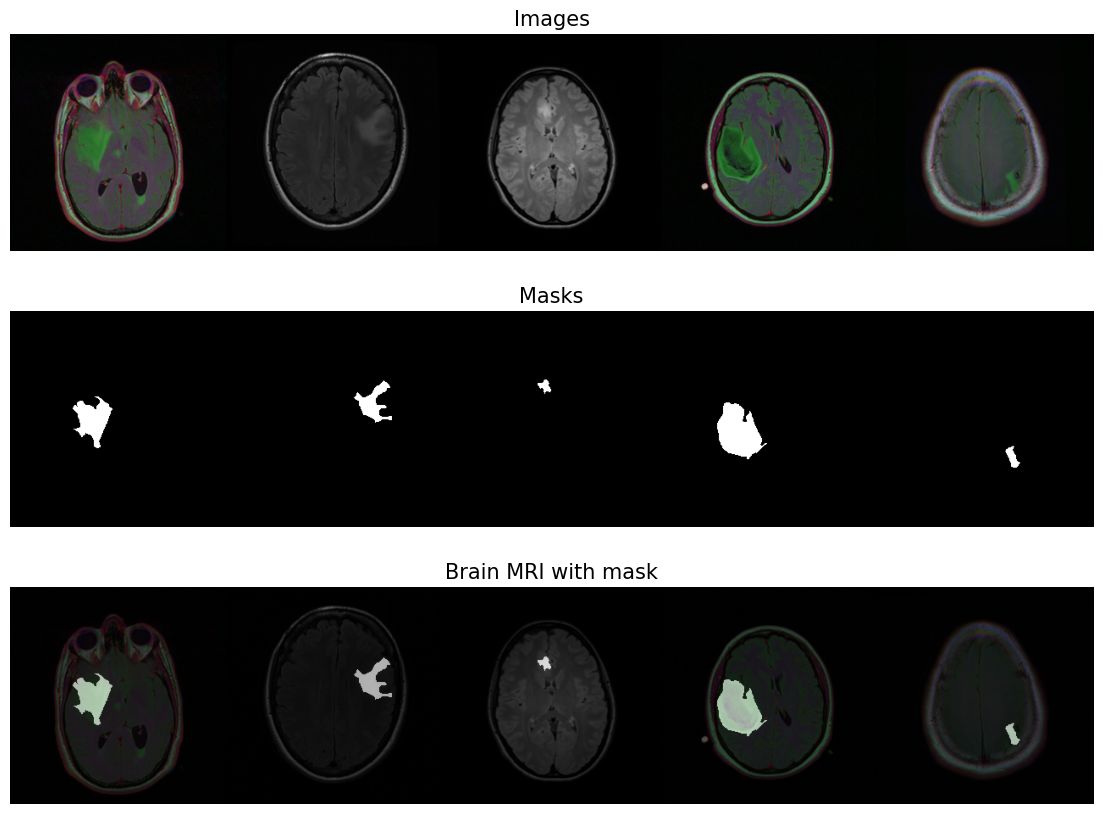

In [ ]:
set_seed()
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

set_seed()

# Prepare the images and masks
images, masks = [], []
df_positive = train_df[train_df['diagnosis'] == 1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)

# Reverse the order of images and masks
images = np.array(images[4::-1])
masks = np.array(masks[4::-1])

# Concatenate the images and masks horizontally
images_concat = np.hstack(images)
masks_concat = np.hstack(masks)

# Plot the images, masks, and overlays
fig = plt.figure(figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 1), axes_pad=0.6)

grid[0].imshow(images_concat)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')

grid[1].imshow(masks_concat)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')

grid[2].imshow(images_concat)
grid[2].imshow(masks_concat, alpha=0.6)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

plt.show()

In [ ]:
# Custom PyTorch Dataset class for loading images and masks from a DataFrame.
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

In [ ]:
# Define transformations for training, validation, and testing datasets using Albumentations library.
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),  # Apply vertical flip with 50% probability
    A.RandomRotate90(p=0.5),  # Rotate randomly by 90 degrees with 50% probability
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  # Randomly shift, scale, and rotate
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability (for data augmentation)
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
])

In [ ]:
# Setting seed for reproducibility across random processes.
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [ ]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [ ]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



## Creating Dataloaders

In [ ]:
batch_size = 64

# Set seed for reproducibility in random operations.
set_seed()
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
set_seed()
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)
test_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [ ]:
# Fetch a batch of data (images and masks) from the training DataLoader (`train_dl`).
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


In [ ]:
# Defines the DoubleConv class, consisting of two consecutive
# convolutional layers each followed by BatchNorm and ReLU.

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

# Defines the Down class, which performs downscaling using MaxPool
# followed by DoubleConv.
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

# Defines the Up class, which performs upscaling followed by DoubleConv.
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Defines the OutConv class, which performs a 1x1 convolution followed by Sigmoid activation.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [ ]:
# Defines the UNet class, a convolutional neural network architecture
# for semantic segmentation.
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

    # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)

    # Decoder (upsampling path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

    # Output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):

    # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

    # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

    # Final output
        logits = self.outc(x)
        return logits

In [ ]:
# Instantiate the UNet model for semantic segmentation,
# with 3 input channels and 1 output channel (binary segmentation).
model = UNet(3, 1).to(device)

# Perform a forward pass through the model with a random input tensor
#of shape (1, 3, 128, 128), moved to the specified device (GPU or CPU).
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)

torch.Size([1, 1, 128, 128])


In [ ]:
# Function to calculate the Dice coefficient metric between prediction and ground truth.
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth.
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss.
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

## Training

In [ ]:
# Function to perform the training loop for the model.
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []

    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

# Convert outputs to numpy array for post-processing
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_dices, train_losses

In [ ]:
# Function to perform evaluation loop for the model.
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

    # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss

### Train Function

In [ ]:
# Function to train the model and evaluate on validation data across epochs.
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice,val_mean_dice))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

### Hyperparameters

In [ ]:
# Define the optimizer with Adam optimizer and initial learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler with ReduceLROnPlateau, monitoring 'max' validation metric, and patience of 3 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Number of epochs for training
num_epochs = 30

In [ ]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/30 |  Train Loss: 1.142, Val Loss: 1.512, Train DICE: 0.471, Val DICE: 0.197
Epoch: 2/30 |  Train Loss: 0.878, Val Loss: 1.185, Train DICE: 0.590, Val DICE: 0.254
Epoch: 3/30 |  Train Loss: 0.634, Val Loss: 0.739, Train DICE: 0.629, Val DICE: 0.624
Epoch: 4/30 |  Train Loss: 0.453, Val Loss: 0.568, Train DICE: 0.670, Val DICE: 0.710
Epoch: 5/30 |  Train Loss: 0.400, Val Loss: 0.780, Train DICE: 0.675, Val DICE: 0.461
Epoch: 6/30 |  Train Loss: 0.352, Val Loss: 0.526, Train DICE: 0.704, Val DICE: 0.694
Epoch: 7/30 |  Train Loss: 0.333, Val Loss: 0.467, Train DICE: 0.716, Val DICE: 0.740
Epoch: 8/30 |  Train Loss: 0.319, Val Loss: 0.508, Train DICE: 0.726, Val DICE: 0.712
Epoch: 9/30 |  Train Loss: 0.306, Val Loss: 0.509, Train DICE: 0.736, Val DICE: 0.708
Epoch: 10/30 |  Train Loss: 0.320, Val Loss: 0.468, Train DICE: 0.721, Val DICE: 0.748
Epoch: 11/30 |  Train Loss: 0.289, Val Loss: 0.469, Train DICE: 0.748, Val DICE: 0.735
Epoch: 12/30 |  Train Loss: 0.276, Val Loss: 0.427, 

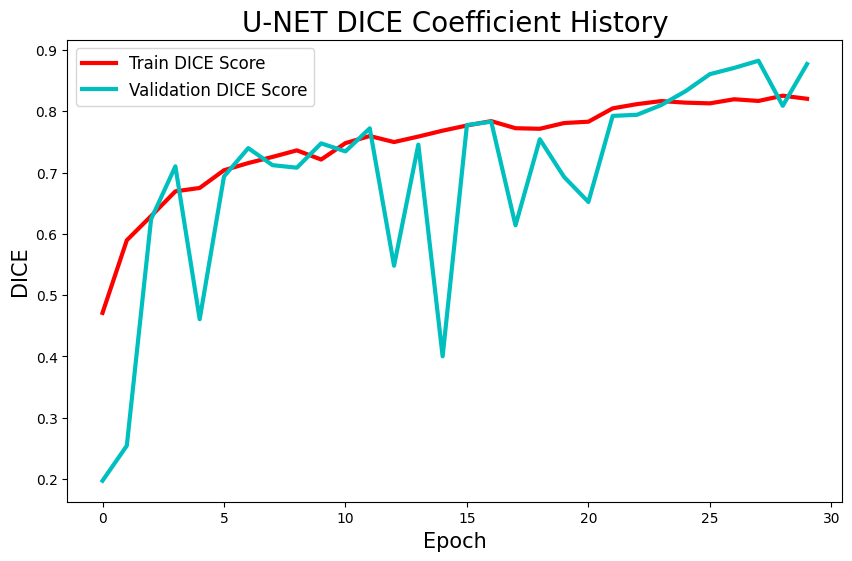

In [ ]:
# Function to plot Dice coefficient history across epochs.
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE Score', lw=3, c="r")
    plt.plot(x, val_dice_history, label='Validation DICE Score', lw=3, c="c")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

# Example usage to plot Dice coefficient history for a UNet model
plot_dice_history('U-NET DICE Coefficient History', train_dice_history, val_dice_history, num_epochs)

In [ ]:
"""# Function to plot loss history across epochs.
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="r")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="c")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

# Example usage to plot loss history for a UNet model
plot_loss_history('U-NET Loss', train_loss_history, val_loss_history, num_epochs)"""

'# Function to plot loss history across epochs.\ndef plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):\n    \n    x = np.arange(num_epochs)\n    fig = plt.figure(figsize=(10, 6))\n    plt.plot(x, train_loss_history, label=\'Train Loss\', lw=3, c="r")\n    plt.plot(x, val_loss_history, label=\'Validation Loss\', lw=3, c="c")\n\n    plt.title(f"{model_name}", fontsize=20)\n    plt.legend(fontsize=12)\n    plt.xlabel("Epoch", fontsize=15)\n    plt.ylabel("Loss", fontsize=15)\n\n    plt.show()\n    \n# Example usage to plot loss history for a UNet model\nplot_loss_history(\'U-NET Loss\', train_loss_history, val_loss_history, num_epochs)'

## Prediction on Test set

In [ ]:
%%time
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

Mean DICE: 87.884%, Loss: 0.317
CPU times: user 1.41 s, sys: 156 ms, total: 1.56 s
Wall time: 2.66 s


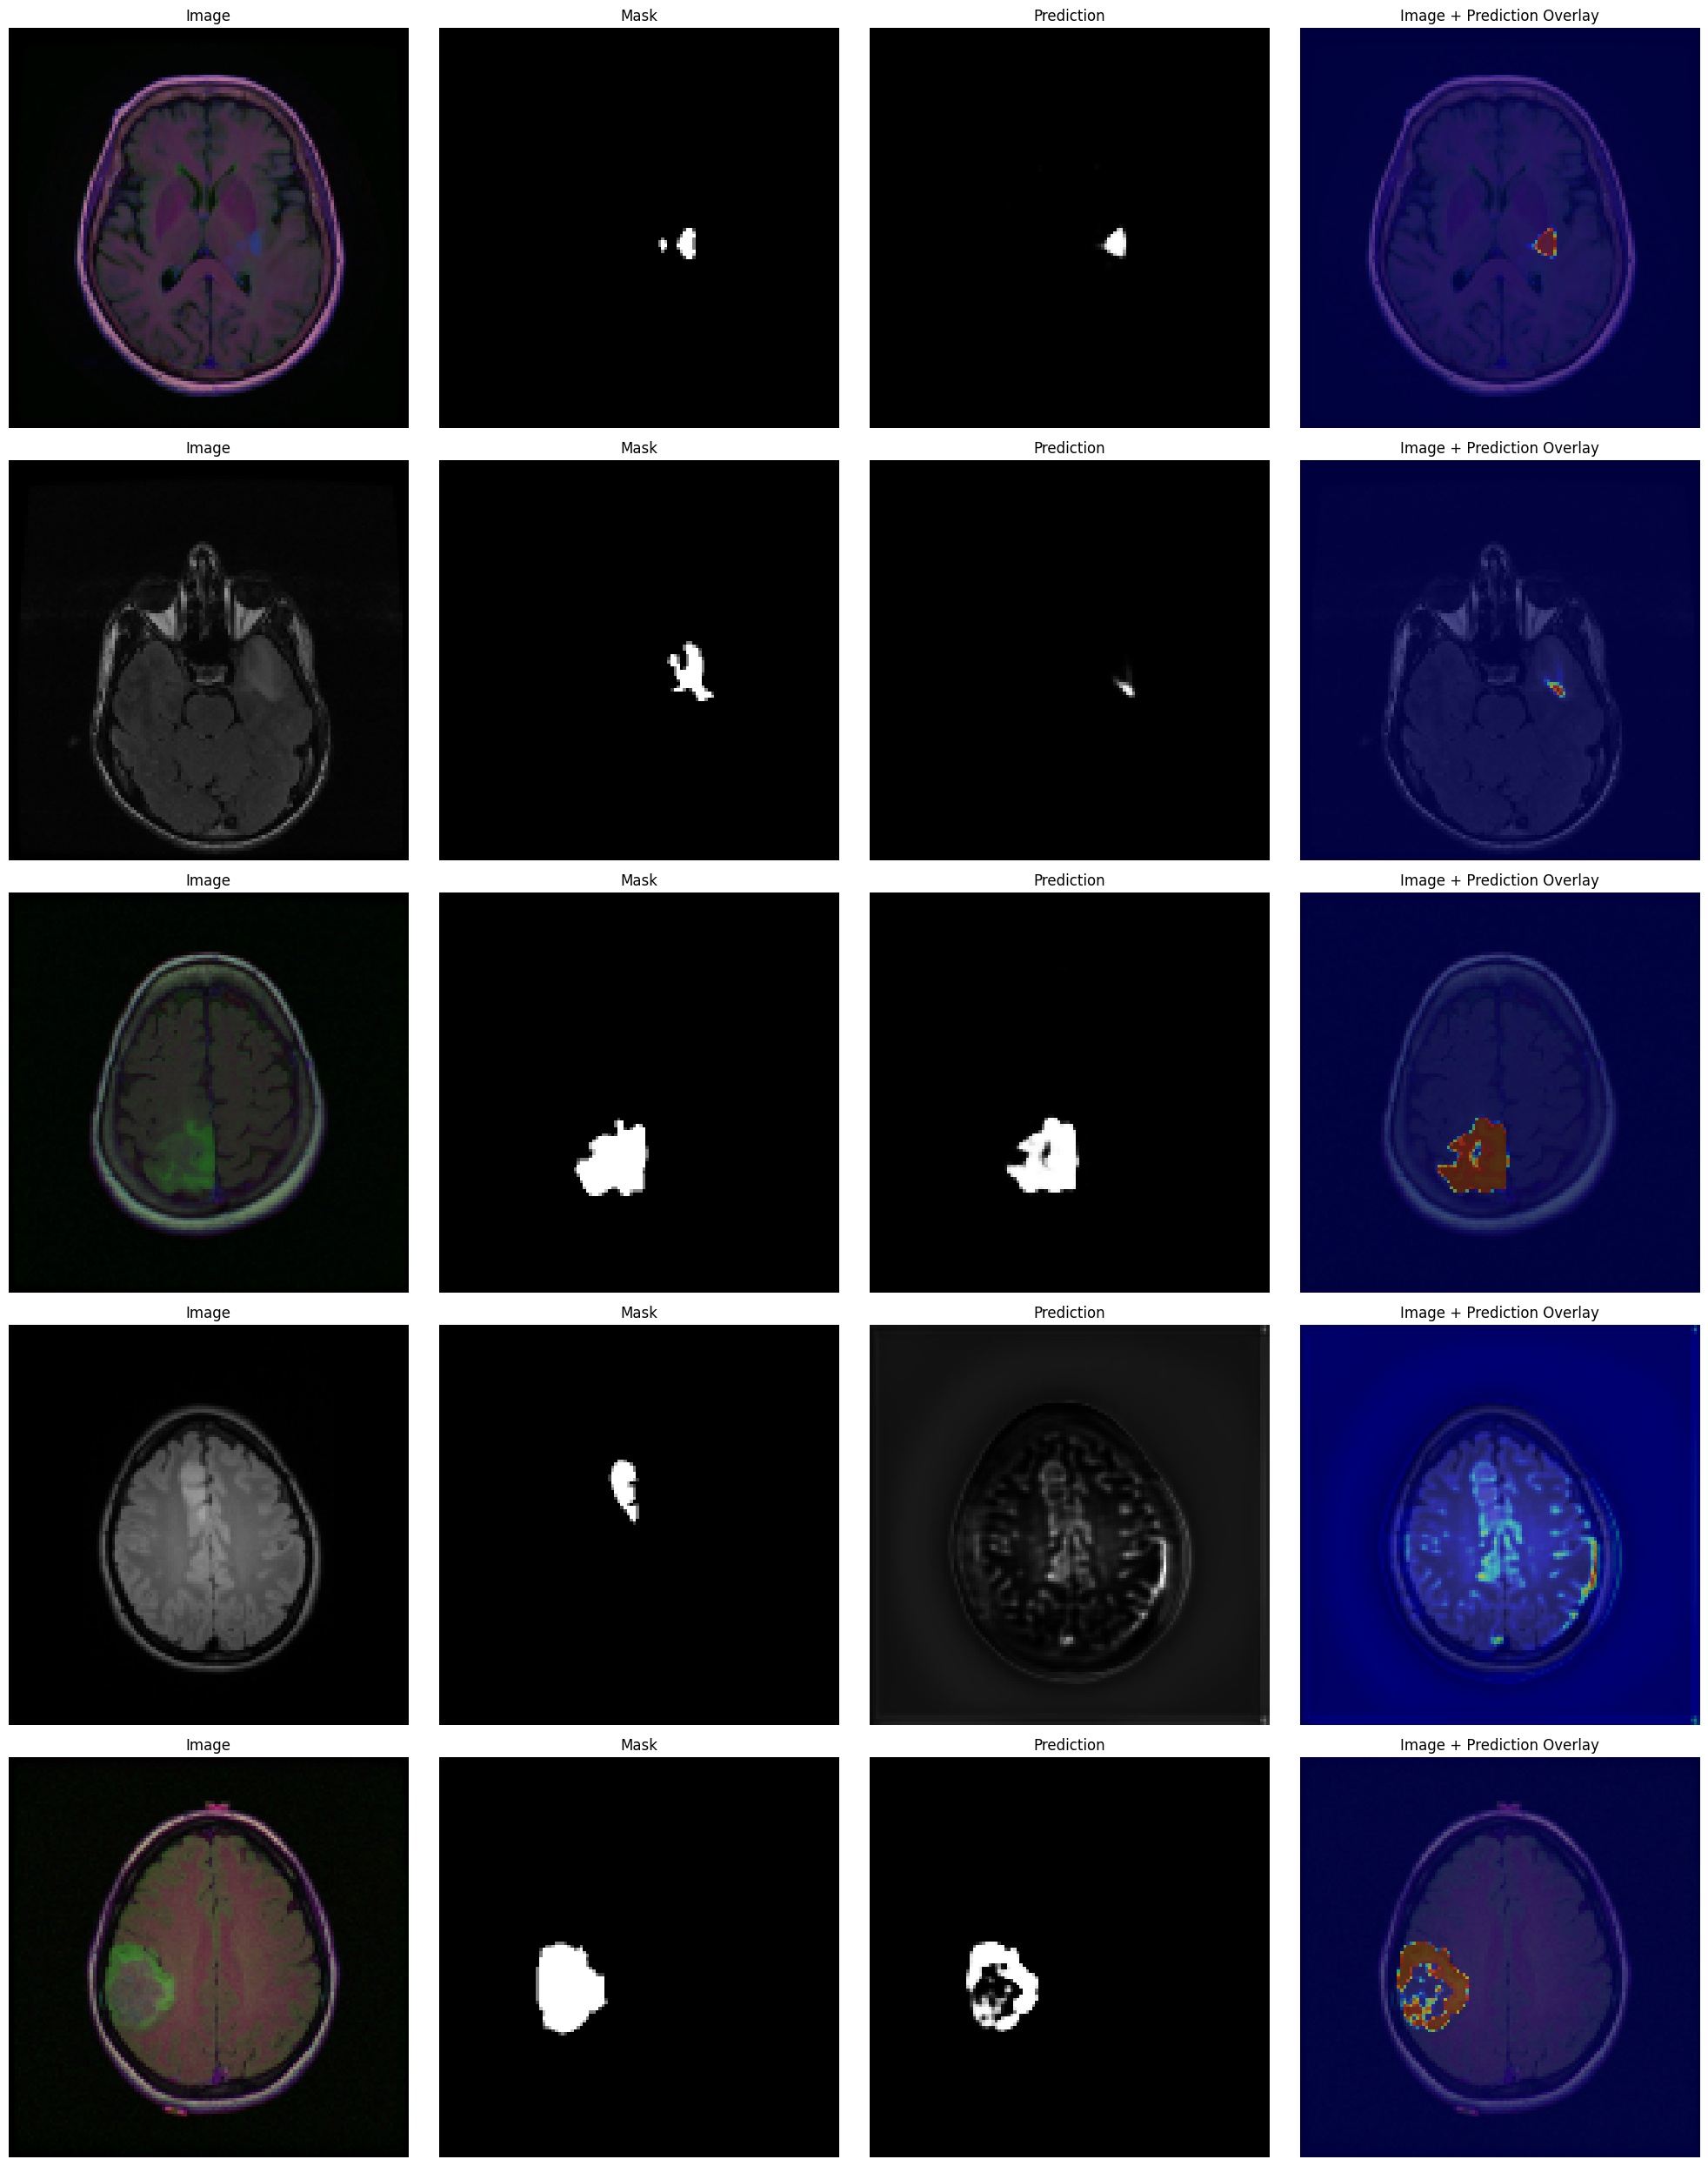

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as tt

# Define the number of images to process
num_images = 5

# Sample 5 images from the test dataframe
sampled_images = test_df[test_df["diagnosis"] == 1].sample(num_images)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_images, ncols=4, figsize=(20, num_images * 5))

for i, test_sample in enumerate(sampled_images.itertuples(index=False)):
    image_path = test_sample[0]
    mask_path = test_sample[1]

    # Load and resize images and masks
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    # Check if the images are loaded properly
    if image is None or mask is None:
        print(f"Error loading image or mask from {image_path} or {mask_path}. Skipping...")
        continue

    image = cv2.resize(image, (128, 128))
    mask = cv2.resize(mask, (128, 128))

    # Prediction
    input_image = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
    input_image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(input_image)

    try:
        pred = model(input_image.to(device))
        pred = pred.detach().cpu().numpy()[0, 0, :, :]
    except Exception as e:
        print(f"Error during model prediction: {e}. Skipping this image...")
        continue

    # Create an overlay image
    overlay = image.copy()
    overlay[pred > 0.5, 1] = 255  # Green for prediction

    # Convert BGR to RGB for plotting
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Plotting
    axes[i, 0].imshow(image_rgb)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_rgb)
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pred, cmap='gray')
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis('off')

    axes[i, 3].imshow(image_rgb)
    axes[i, 3].imshow(pred, cmap='jet', alpha=0.5)
    axes[i, 3].set_title("Image + Prediction Overlay")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


In [2]:
## Saving the Model
torch.save(model.state_dict(), 'brain-mri-unet.pth')


NameError: name 'torch' is not defined

<ipython-input-157-f69ec56d7f50>:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


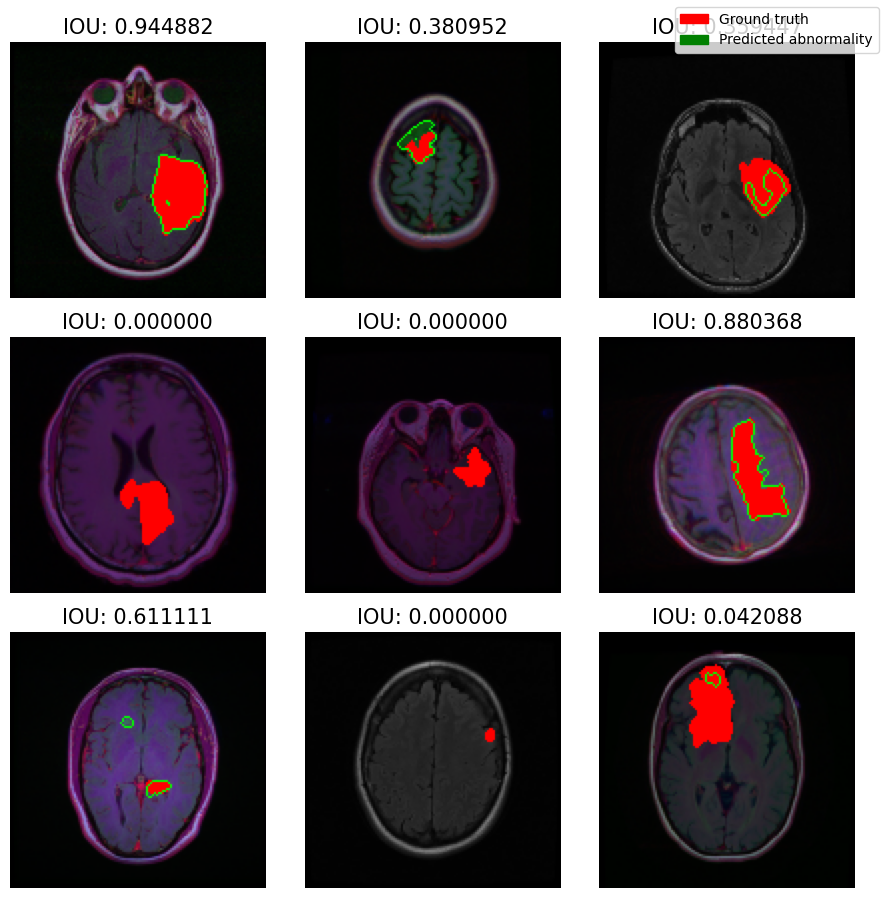

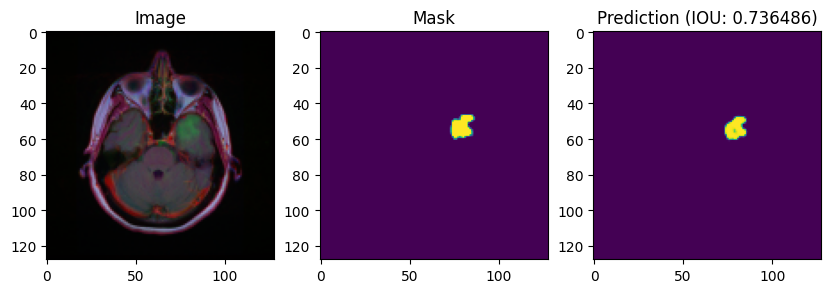

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torchvision.transforms as tt
from skimage.morphology import binary_dilation

# Function to compute Intersection over Union (IoU)
def compute_iou(prediction, mask):
    prediction = prediction.bool()
    mask = mask.bool()
    intersection = (prediction & mask).float().sum()
    union = (prediction | mask).float().sum()
    iou_score = (intersection + 1e-7) / (union + 1e-7)
    return iou_score.item()

# Set device and model (assuming you have `model` defined)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Visualizing segmentation results with IoU scores
%matplotlib inline
figure_width = 3
figure_columns = 3
num_examples = figure_columns * figure_width
fig, axes = plt.subplots(figure_columns, figure_width, figsize=(3 * figure_width, 3 * figure_columns), constrained_layout=True)

# Add legend for the colors used in the visualization
fig.legend(loc='upper right', handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')
])

example_index = 0

with torch.no_grad():
    for idx in range(num_examples):
        # Select a sample from the test set with diagnosis label 1
        test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
        image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
        mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Convert mask to grayscale

        # Prediction
        image_tensor = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
        image_tensor = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image_tensor)
        prediction = model(image_tensor.to(device))
        prediction = prediction.detach().cpu().numpy()[0, 0, :, :]
        prediction_bin = torch.tensor(prediction > 0.5).int()

        # Compute IoU
        iou_score = compute_iou(prediction_bin, torch.tensor(mask).int())

        # Generate edges for visualization
        prediction_edges = prediction_bin - binary_dilation(prediction_bin)
        ground_truth_edges = torch.tensor(mask) - binary_dilation(torch.tensor(mask))

        # Overlay edges on the image for visualization
        overlay_image = image.copy()
        overlay_image[ground_truth_edges.bool()] = [255, 0, 0]  # Red for ground truth edges
        overlay_image[prediction_edges.bool()] = [0, 255, 0]    # Green for predicted edges

        # Display the segmented image with IoU score
        axes[example_index // figure_width][example_index % figure_width].imshow(overlay_image)
        axes[example_index // figure_width][example_index % figure_width].set_title(f'IOU: {iou_score:.6f}', fontsize=15)
        axes[example_index // figure_width][example_index % figure_width].axis('off')

        example_index += 1
        if example_index >= num_examples:
            break

plt.tight_layout()
plt.show()

# Additional script to visualize a single sample with its prediction, ground truth, and IoU score

# Select a sample from the test set with diagnosis label 1 and resize image and mask
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Convert mask to grayscale

# Prediction
image_tensor = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
image_tensor = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image_tensor)
prediction = model(image_tensor.to(device))
prediction = prediction.detach().cpu().numpy()[0, 0, :, :]

# Compute IoU for the single sample
iou_score = compute_iou(torch.tensor(prediction > 0.7), torch.tensor(mask))

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[2].imshow(prediction)
ax[2].set_title(f'Prediction (IOU: {iou_score:.6f})')

plt.show()

In [ ]:
# Initialize variables to accumulate IoU scores
total_iou = 0.0
num_examples = len(test_df[test_df["diagnosis"] == 1])  # Total number of samples in the test dataset

# Iterate through the test dataset
with torch.no_grad():
    for idx in range(num_examples):
        # Select a sample from the test set with diagnosis label 1
        test_sample = test_df[test_df["diagnosis"] == 1].iloc[idx]
        image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
        mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Convert mask to grayscale

        # Prediction
        image_tensor = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
        image_tensor = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image_tensor)
        prediction = model(image_tensor.to(device))
        prediction = prediction.detach().cpu().numpy()[0, 0, :, :]
        prediction_bin = torch.tensor(prediction > 0.5).int()

        # Compute IoU
        iou_score = compute_iou(prediction_bin, torch.tensor(mask).int())

        # Accumulate IoU score
        total_iou += iou_score

# Compute average IoU
average_iou = total_iou / num_examples

# Print Mean IoU as a percentage
print(f'Mean IoU: {average_iou * 100:.2f}%')


<ipython-input-155-583334583ffa>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
<ipython-input-155-583334583ffa>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Convert mask to grayscale


Mean IoU: 61.61%
